## Bitcoin Price Prediction

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from preprocessing.data_preprocessor import FinancialDataPreprocessor

preprocessor = FinancialDataPreprocessor()

preprocessor.load_data(
    bitcoin_path=r"C:\Users\enesm\OneDrive\Masaüstü\tubitak\data\Bitcoin Historical Data.csv",
    usd_path=r"C:\Users\enesm\OneDrive\Masaüstü\tubitak\data\dolar.csv",
    gold_path=r"C:\Users\enesm\OneDrive\Masaüstü\tubitak\data\XAU_USD Geçmiş Verileri.csv",
)

merged_df = preprocessor.merge_data()

merged_df.to_csv(
    r"C:\Users\enesm\OneDrive\Masaüstü\tubitak\data\merged_data.csv", index=False
)

data_info = preprocessor.get_data_info()
print("Data Shape:", data_info["shape"])
print("Date Range:", data_info["date_range"])
print("Unique Dates:", data_info["unique_dates"])
print("Missing Values:", data_info["missing_values"])
merged_df.head()

Data Shape: (2831, 14)
Date Range: (Timestamp('2017-01-22 00:00:00'), Timestamp('2024-10-22 00:00:00'))
Unique Dates: 2831
Missing Values: {'Date': 0, 'Price': 0, 'Open': 0, 'High': 0, 'Low': 0, 'Vol.': 0, 'Change %': 0, 'usd_buy': 0, 'usd_sell': 0, 'gold_Price': 1, 'gold_Open': 1, 'gold_High': 1, 'gold_Low': 1, 'gold_Change': 1}


c:\Users\enesm\OneDrive\Masaüstü\tubitak\src\preprocessing\data_preprocessor.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[numeric_columns] = df[numeric_columns].fillna(method="ffill")
c:\Users\enesm\OneDrive\Masaüstü\tubitak\src\preprocessing\data_preprocessor.py:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.drop(columns=["Hac."], errors="ignore").fillna(method="ffill")
c:\Users\enesm\OneDrive\Masaüstü\tubitak\src\preprocessing\data_preprocessor.py:83: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.merged_data = merged_data.fillna(method="ffill").sort_values("Date")


,Date,Price,Open,High,Low,Vol.,Change %,usd_buy,usd_sell,gold_Price,gold_Open,gold_High,gold_Low,gold_Change
0,2017-01-22,918.8,919.8,938.4,888.6,47930.0,-0.11,3.79,3.80,NaN,NaN,NaN,NaN,NaN
1,2017-01-23,921.5,918.8,928.0,910.8,32740.0,0.29,3.82,3.82,1217.48,1209.43,1219.54,1209.27,0.62
2,2017-01-24,893.8,921.5,925.6,889.2,58870.0,-3.01,3.77,3.77,1208.81,1217.40,1219.66,1206.02,-0.71
3,2017-01-25,894.4,893.8,905.7,883.6,37900.0,0.07,3.75,3.76,1200.31,1208.79,1209.84,1192.83,-0.70
4,2017-01-26,915.6,894.4,919.3,893.5,33800.0,2.36,3.80,3.81,1188.57,1199.93,1202.67,1184.11,-0.98


In [3]:
from visualization.data_eda import FinancialDataEDA

eda = FinancialDataEDA(merged_df)

time_series = eda.plot_time_series()
time_series.show()

In [4]:
correlation_matrix = eda.plot_correlation_matrix()
correlation_matrix.show()

In [5]:
# returns = eda.plot_returns_distribution()
# returns.show()

detailed_corr = eda.get_detailed_correlations()
print("\nTop 10 Strongest Correlations:")
print(detailed_corr.head(15))


Top 10 Strongest Correlations:
         Asset 1        Asset 2  Correlation
0   USD Buy Rate  USD Sell Rate     1.000000
0      Gold Open      Gold High     0.999606
0     Gold Price       Gold Low     0.999602
0     Gold Price      Gold High     0.999526
0      Gold Open       Gold Low     0.999469
0  Bitcoin Price   Bitcoin High     0.999437
0   Bitcoin Open   Bitcoin High     0.999407
0      Gold High       Gold Low     0.999407
0  Bitcoin Price    Bitcoin Low     0.999292
0   Bitcoin Open    Bitcoin Low     0.999034
0     Gold Price      Gold Open     0.998995
0   Bitcoin High    Bitcoin Low     0.998833
0  Bitcoin Price   Bitcoin Open     0.998700
0  USD Sell Rate       Gold Low     0.840319
0   USD Buy Rate       Gold Low     0.840316


c:\Users\enesm\OneDrive\Masaüstü\tubitak\src\visualization\data_eda.py:137: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [6]:
# risk metrics
# risk_metrics = eda.generate_risk_metrics()
# for asset, metrics in risk_metrics.items():
#    print(f"\n{asset} Metrics:")
#    for metric, value in metrics.items():
#        print(f"{metric}: {value:.2f}")

In [7]:
from preprocessing.model_preprocessor import FinancialDataPreprocessor


preprocessor = FinancialDataPreprocessor(lookback_period=30)

processed_data = preprocessor.prepare_data(
    df=merged_df,
    train_start="2023-09-01",
    train_end="2024-09-14",
    test_start="2024-09-15",
    test_end="2024-09-30",
)

train_data = processed_data["train"]
test_data = processed_data["test"]

preprocessor.check_data_quality(train_data, test_data)

Training veri boyutu: (380, 16)
Test veri boyutu: (16, 16)

Veri Kalitesi Raporu:
--------------------------------------------------

Train veri boyutu: (380, 46)
Test veri boyutu: (16, 46)

Train seti eksik değer sayıları:
Series([], dtype: int64)

Test seti eksik değer sayıları:
Series([], dtype: int64)

Train seti tarih aralığı:
Başlangıç: 2023-09-01 00:00:00
Bitiş: 2024-09-14 00:00:00

Test seti tarih aralığı:
Başlangıç: 2024-09-15 00:00:00
Bitiş: 2024-09-30 00:00:00


c:\Users\enesm\OneDrive\Masaüstü\tubitak\src\preprocessing\model_preprocessor.py:107: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

c:\Users\enesm\OneDrive\Masaüstü\tubitak\src\preprocessing\model_preprocessor.py:107: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



### Feature Selection

In [8]:
train_data.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'usd_buy',
       'usd_sell', 'gold_Price', 'gold_Open', 'gold_High', 'gold_Low',
       'gold_Change', 'Month', 'Year', 'RSI', 'MA_7', 'EMA_7', 'MA_14',
       'EMA_14', 'MA_21', 'EMA_21', 'MACD', 'MACD_Signal', 'BB_middle',
       'BB_upper', 'BB_lower', 'ROC_1', 'ROC_3', 'ROC_7', 'Volatility', 'TR',
       'ATR', 'Momentum', 'Volume_MA', 'Volume_ROC', 'BTC_Gold_Ratio',
       'BTC_USD_Ratio', 'Day_of_Week', 'Quarter', 'Day_of_Year', 'Is_Weekend',
       'Body_Size', 'Upper_Shadow', 'Lower_Shadow'],
      dtype='object')

In [9]:
test_data.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'usd_buy',
       'usd_sell', 'gold_Price', 'gold_Open', 'gold_High', 'gold_Low',
       'gold_Change', 'Month', 'Year', 'RSI', 'MA_7', 'EMA_7', 'MA_14',
       'EMA_14', 'MA_21', 'EMA_21', 'MACD', 'MACD_Signal', 'BB_middle',
       'BB_upper', 'BB_lower', 'ROC_1', 'ROC_3', 'ROC_7', 'Volatility', 'TR',
       'ATR', 'Momentum', 'Volume_MA', 'Volume_ROC', 'BTC_Gold_Ratio',
       'BTC_USD_Ratio', 'Day_of_Week', 'Quarter', 'Day_of_Year', 'Is_Weekend',
       'Body_Size', 'Upper_Shadow', 'Lower_Shadow'],
      dtype='object')

In [10]:
# selected_features = ["feature1", "feature2", "feature3"]

# train_data = train_data[selected_features]
# test_data = test_data[selected_features]

### Correlation After Feature Engineering  

In [11]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.colheader_justify", "center")

correlation_matrix = train_data.corr()

mask = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
high_corr_matrix = correlation_matrix.where(mask)

high_corr = (
    high_corr_matrix.stack()
    .reset_index()
    .rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: "Correlation"})
)


threshold = 0.8
high_corr_filtered = high_corr[high_corr["Correlation"].abs() >= threshold]

high_corr_filtered[["Feature 1", "Feature 2"]] = np.sort(
    high_corr_filtered[["Feature 1", "Feature 2"]], axis=1
)
high_corr_filtered = high_corr_filtered.drop_duplicates(
    subset=["Feature 1", "Feature 2"]
)

high_corr_filtered = high_corr_filtered.sort_values(
    by="Correlation", ascending=False
).reset_index(drop=True)
high_corr_filtered.index += 1
high_corr_filtered.index.name = "Index"

print(high_corr_filtered)

         Feature 1       Feature 2     Correlation
Index                                             
1             usd_buy        usd_sell   0.999999  
2           BB_middle           MA_21   0.999935  
3               EMA_7            MA_7   0.999472  
4              EMA_14           MA_14   0.999074  
5           BB_middle          EMA_21   0.998788  
6              EMA_21           MA_21   0.998654  
7              EMA_14          EMA_21   0.998637  
8                High           Price   0.998223  
9              EMA_21           MA_14   0.997989  
10           gold_Low      gold_Price   0.997886  
11          gold_High       gold_Open   0.997769  
12           gold_Low       gold_Open   0.997735  
13             EMA_14           EMA_7   0.997581  
14          BB_middle           MA_14   0.997555  
15               High            Open   0.997484  
16                Low           Price   0.997421  
17          gold_High      gold_Price   0.997328  
18          gold_High        go

C:\Users\enesm\AppData\Local\Temp\ipykernel_31960\4247043764.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
from model.models import FinancialModelPipeline

pipeline = FinancialModelPipeline(train_data, test_data)
pipeline.train_and_evaluate()


+-------------------+---------------+--------+-------+--------+--------+-----------------+-----------------+---------------+
| Model             |   Scaled RMSE | RMSE   | MAE   | MAPE   |     R² | CV RMSE         | CV MAE          | CV MAPE       |
+===================+===============+========+=======+========+========+=================+=================+===============+
| Linear_Regression |      0.011364 | 166    | 129   | 0.21%  | 0.9942 | 953,636,990,903 | 294,298,767,006 | 668375251.16% |
+-------------------+---------------+--------+-------+--------+--------+-----------------+-----------------+---------------+
| Decision_Tree     |      0.09756  | 1,429  | 1,135 | 1.80%  | 0.5719 | 4,617           | 3,440           | 6.49%         |
+-------------------+---------------+--------+-------+--------+--------+-----------------+-----------------+---------------+
| SVR               |      0.119206 | 1,746  | 1,529 | 2.39%  | 0.3609 | 7,667           | 6,457           | 11.65%        |

In [13]:
from visualization.model_visualizations import ModelVisualizer

visualizer = ModelVisualizer(pipeline)

# model metrics
fig_metrics = visualizer.plot_model_metrics()
fig_metrics.show()

# best model
fig_best = visualizer.plot_best_model_predictions()
fig_best.show()

# all predictions
fig_all = visualizer.plot_all_predictions()
fig_all.show()

### Feature Importance

In [14]:
# Decision_Tree, Random_Forest, XGBoost, LightGBM, CatBoost, AdaBoost
fig_importance = visualizer.plot_feature_importance("Random_Forest")
if fig_importance:
    fig_importance.show()

### Model Parametre Tuning

In [15]:
# tune selected models
# pipeline.tune_models(['Random_Forest', 'XGBoost'])

# tune all models
# pipeline.tune_models()

# tuning results
# pipeline.train_and_evaluate()

### LSTM

In [16]:
import json
from datetime import datetime
from model.lstm_model import FinancialLSTM
from preprocessing.lstm_model_preprocessor import LSTMDataPreprocessor
from preprocessing.model_preprocessor import FinancialDataPreprocessor


df = pd.read_csv(r"C:\Users\enesm\OneDrive\Masaüstü\tubitak\data\merged_data.csv")
df["Date"] = pd.to_datetime(df["Date"])


sequence_length = 20

data_preprocessor = FinancialDataPreprocessor(lookback_period=30)
lstm_preprocessor = LSTMDataPreprocessor(
    sequence_length=sequence_length,
    target_column="Price",
    feature_columns=[
        "Price",
        "High",
        "Low",
        "Vol.",
        "MA_7",
        "RSI",
        "MACD",
        "BB_middle",
        "Price_Momentum_1",
        "Price_Momentum_3",
    ],
)

preprocessed_data = data_preprocessor.prepare_data(
    df=df,
    train_start="2022-01-01",
    train_end="2024-08-15",  
    test_start="2024-08-16",
    test_end="2024-09-30",
)

lstm_data = lstm_preprocessor.prepare_lstm_data(preprocessed_data)

model = FinancialLSTM(
    sequence_length=sequence_length,
    epochs=150,
    batch_size=32,
    lstm_units=[128, 64, 32],
    dropout_rate=0.1,
)

metrics = model.train(lstm_data)
print("\nTraining metrics:", metrics)

predictions = model.predict(lstm_data["test"]["X"])
predictions = lstm_preprocessor.inverse_transform_predictions(predictions)

test_dates = preprocessed_data["test"]["Date"].values[
    sequence_length : len(predictions) + sequence_length
]
y_true = preprocessed_data["test"][lstm_preprocessor.target_column].values[
    sequence_length : len(predictions) + sequence_length
]

model.plot_predictions(test_dates, y_true, predictions.flatten())

eval_metrics = model.evaluate_predictions(y_true, predictions.flatten())
print("\nTest Set Performance Metrics:")
print(f"MAE: ${eval_metrics['mae']:,.2f}")
print(f"RMSE: ${eval_metrics['rmse']:,.2f}")
print(f"R2 Score: {eval_metrics['r2']:.4f}")
print(f"MAPE: {eval_metrics['mape']:.2f}%")


performance_log = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "metrics": eval_metrics,
    "model_params": {
        "sequence_length": sequence_length,
        "lstm_units": [128, 64, 32],
        "dropout_rate": 0.1,
        "batch_size": 32,
        "epochs": 150,
    },
    "train_period": f"{preprocessed_data['train']['Date'].iloc[0]} to {preprocessed_data['train']['Date'].iloc[-1]}",
    "test_period": f"{preprocessed_data['test']['Date'].iloc[0]} to {preprocessed_data['test']['Date'].iloc[-1]}",
}

with open("model\lstm_performance_log.json", "w") as f:
    json.dump(performance_log, f, indent=4)

print("\nModel performance saved to 'model_performance_log.json'")

Training veri boyutu: (958, 14)
Test veri boyutu: (46, 14)


c:\Users\enesm\OneDrive\Masaüstü\tubitak\src\preprocessing\model_preprocessor.py:107: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

c:\Users\enesm\OneDrive\Masaüstü\tubitak\src\preprocessing\model_preprocessor.py:107: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

c:\Users\enesm\OneDrive\Masaüstü\tubitak\src\preprocessing\lstm_model_preprocessor.py:71: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

c:\Users\enesm\OneDrive\Masaüstü\tubitak\src\preprocessing\lstm_model_preprocessor.py:71: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Epoch 1/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 1.1697 - mae: 0.7755 - val_loss: 1.2702 - val_mae: 1.0283 - learning_rate: 0.0010
Epoch 2/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.5088 - mae: 0.4211 - val_loss: 1.0606 - val_mae: 0.9095 - learning_rate: 0.0010
Epoch 3/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4072 - mae: 0.3356 - val_loss: 0.9558 - val_mae: 0.8413 - learning_rate: 0.0010
Epoch 4/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3814 - mae: 0.3120 - val_loss: 0.7833 - val_mae: 0.7190 - learning_rate: 0.0010
Epoch 5/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.3592 - mae: 0.2819 - val_loss: 0.8618 - val_mae: 0.7823 - learning_rate: 0.0010
Epoch 6/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.3343 - mae: 0.2602 - val_loss: 0.5022 - val_mae: 0.4809 - learning_rate: 0.0010
Epoch 7/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.3291 - mae: 0.2539 - val_loss: 0.3874 - val_mae: 0.3530 - learning_rate: 0.0010
Epoch 


Training metrics: {'train_loss': 0.22025537490844727, 'train_mae': 0.15147164463996887, 'val_loss': 0.24598243832588196, 'val_mae': 0.2041003555059433}



Test Set Performance Metrics:
MAE: $982.65
RMSE: $1,247.55
R2 Score: 0.8842
MAPE: 1.64%

Model performance saved to 'model_performance_log.json'


### Autogluon

c:\Users\enesm\OneDrive\Masaüstü\tubitak\src\preprocessing\model_preprocessor.py:107: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

c:\Users\enesm\OneDrive\Masaüstü\tubitak\src\preprocessing\model_preprocessor.py:107: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.6
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          16
Memory Avail:       3.81 GB / 15.41 GB (24.7%)
Disk Space Avail:   96.62 GB / 393.12 GB (24.6%)
Presets specified: ['high_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): nu

Veri hazırlanıyor...
Training veri boyutu: (988, 14)
Test veri boyutu: (16, 14)
Train veri boyutu: (987, 47)
Test veri boyutu: (15, 47)
Kullanılan feature sayısı: 39

Model eğitimi başlıyor...


Leaderboard on holdout data (DyStack):
              model             score_holdout   score_val        eval_metric         pred_time_test  pred_time_val  fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0          XGBoost_BAG_L2_FULL  -1221.957707  -1403.373226  root_mean_squared_error     0.149494            NaN     3.804513         0.008002                      NaN             0.196158            2         True        20    
1     WeightedEnsemble_L2_FULL  -1246.203877  -1266.196459  root_mean_squared_error     0.075971            NaN     1.004792         0.002000                      NaN             0.018897            2         True        11    
2     WeightedEnsemble_L3_FULL  -1248.916306  -1262.518048  root_mean_squared_error     0.212573            NaN     4.288102         0.001000                      NaN             0.019391            3         True        22    
3     ExtraTrees_2_BAG_L2_FULL  -1252.945912  -12


Model özeti:
*** Summary of fit() ***
Estimated performance of each model:
              model              score_val        eval_metric         pred_time_val  fit_time   pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0          WeightedEnsemble_L2 -1230.436877  root_mean_squared_error    0.143630      4.005283         0.001000              0.017003           2         False       11    
1          ExtraTrees_2_BAG_L1 -1234.179962  root_mean_squared_error    0.085570      0.478616         0.085570              0.478616           1          True        8    
2            ExtraTrees_BAG_L1 -1258.158811  root_mean_squared_error    0.044396      0.220672         0.044396              0.220672           1          True        7    
3        RandomForest_2_BAG_L1 -1320.235894  root_mean_squared_error    0.080309      0.685094         0.080309              0.685094           1          True        4    
4          RandomForest_BAG_L1 -1328.664960  root_mean_squa

	0.66s	= Actual runtime (Completed 5 of 5 shuffle sets)



Model Performans Metrikleri:
------------------------------
RMSE: 3127.5605
MAE: 2818.6910
R2: -1.4491


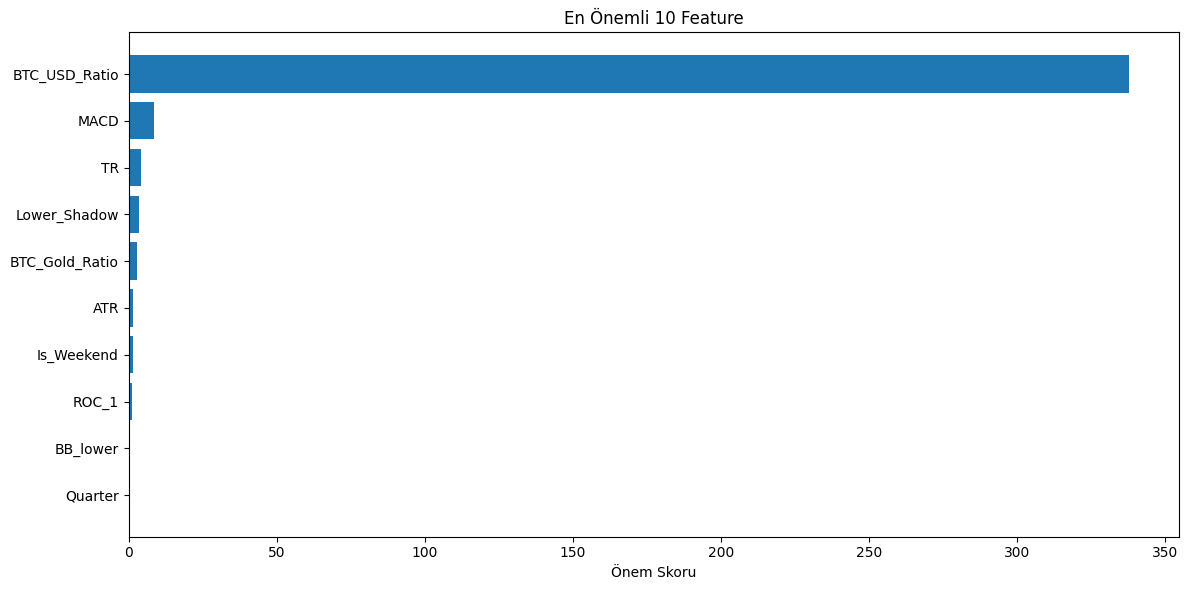

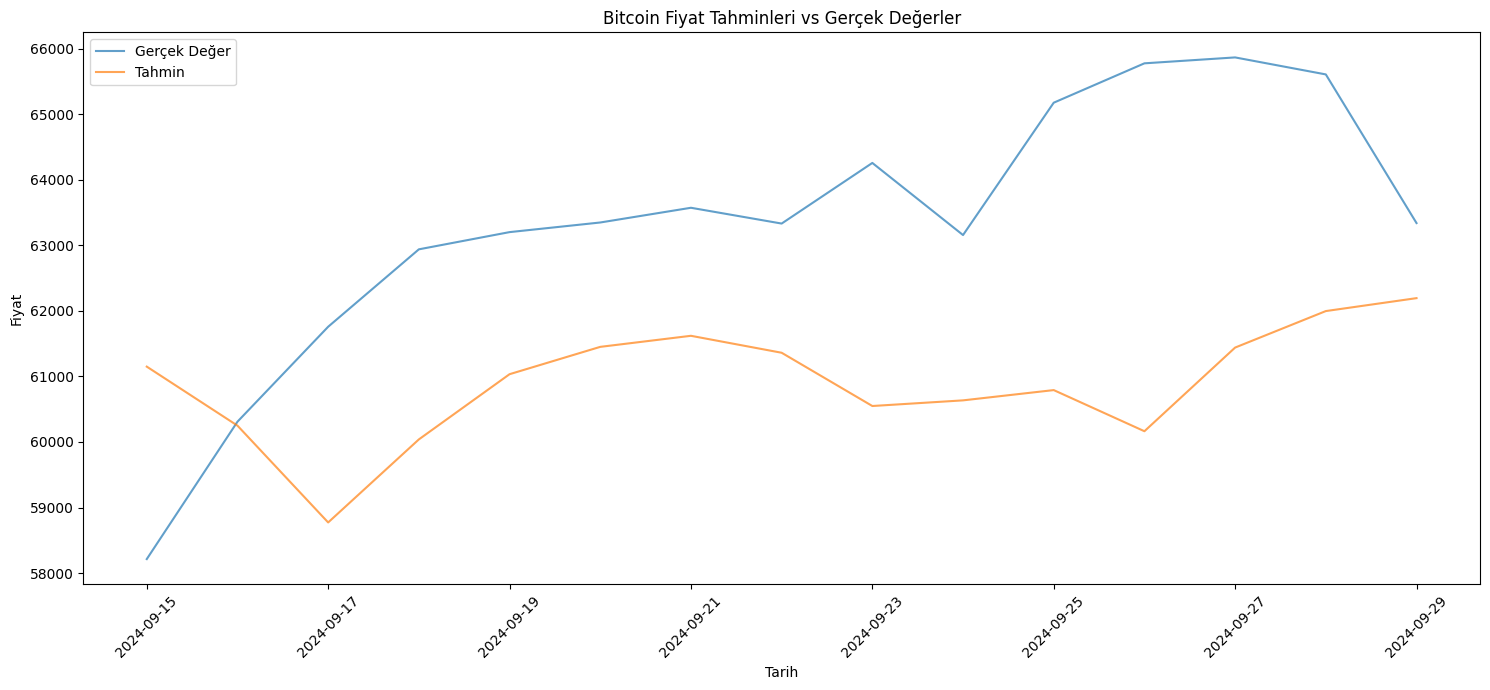

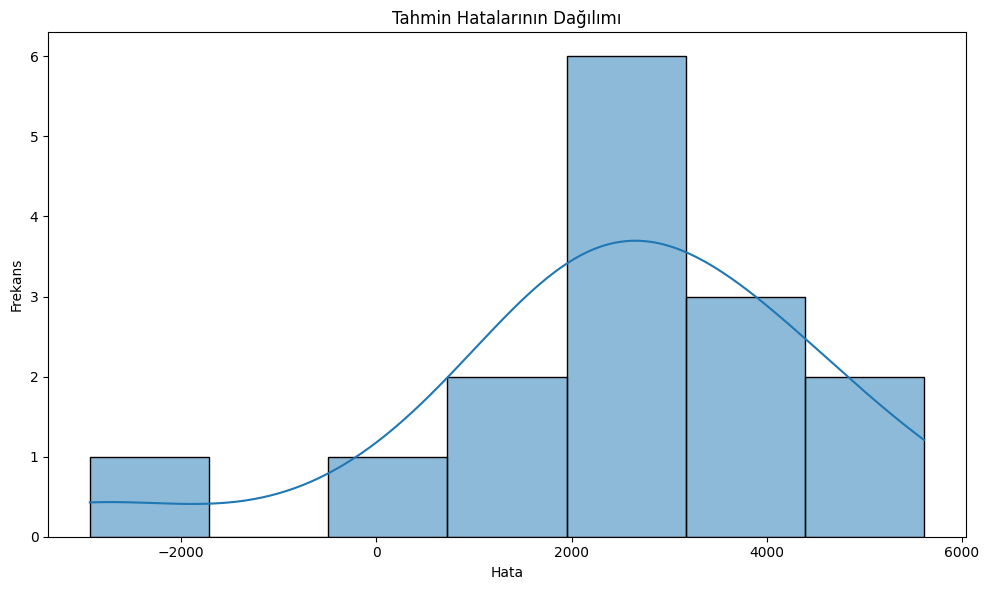


Tahminler 'C:\Users\enesm\OneDrive\Masaüstü\tubitak\src\model\autogluon_predictions.csv' dosyasına kaydedildi.


In [18]:
from model.automl_autogluon import BitcoinPricePredictor

PARAMS = {
    'data_path': r'C:\Users\enesm\OneDrive\Masaüstü\tubitak\data\merged_data.csv',  
    'train_start':"2022-01-01",
    'train_end':"2024-09-14",
    'test_start':"2024-09-15",
    'test_end':"2024-09-30",
    'time_limit': 600  
}

predictor = BitcoinPricePredictor()

print("Veri hazırlanıyor...")
train_data, test_data = predictor.prepare_data(
    PARAMS['data_path'],
    PARAMS['train_start'],
    PARAMS['train_end'],
    PARAMS['test_start'],
    PARAMS['test_end']
)

print("\nModel eğitimi başlıyor...")
predictor.train_model(time_limit=PARAMS['time_limit'])

print("\nModel değerlendiriliyor...")
results = predictor.evaluate_model()

print("\nModel Performans Metrikleri:")
print("-" * 30)
for metric, value in results['metrics'].items():
    print(f"{metric}: {value:.4f}")

plt.figure(figsize=(12, 6))

importance_df = results['feature_importance']
if isinstance(importance_df, pd.DataFrame):
    importance_series = importance_df.iloc[:, 0]
else:
    importance_series = importance_df

importance_series = importance_series.sort_values(ascending=True)
top_10_features = importance_series.tail(10)

y_pos = np.arange(len(top_10_features))
plt.barh(y_pos, top_10_features.values)
plt.yticks(y_pos, top_10_features.index)
plt.title('En Önemli 10 Feature')
plt.xlabel('Önem Skoru')
plt.tight_layout()
plt.show()

predictions_df = results['predictions']
plt.figure(figsize=(15, 7))
plt.plot(test_data['Date'].values, predictions_df['actual'], label='Gerçek Değer', alpha=0.7)
plt.plot(test_data['Date'].values, predictions_df['predicted'], label='Tahmin', alpha=0.7)
plt.title('Bitcoin Fiyat Tahminleri vs Gerçek Değerler')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
errors = predictions_df['actual'] - predictions_df['predicted']
sns.histplot(errors, kde=True)
plt.title('Tahmin Hatalarının Dağılımı')
plt.xlabel('Hata')
plt.ylabel('Frekans')
plt.tight_layout()
plt.show()

results_df = pd.DataFrame({
    'Date': test_data['Date'],
    'Actual': predictions_df['actual'],
    'Predicted': predictions_df['predicted'],
    'Error': errors
})

results_path = r'C:\Users\enesm\OneDrive\Masaüstü\tubitak\src\model\autogluon_predictions.csv'
results_df.to_csv(results_path, index=False)
print(f"\nTahminler '{results_path}' dosyasına kaydedildi.")